In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data Load

In [3]:
import pandas as pd

# Load the data from a CSV file
df = pd.read_csv('../data/preprocessed_v1.csv')

In [4]:
print(df.shape)

(75443, 15)


In [5]:
df.head()

,amount,createdAt,recipient_accountNumber,recipient_full_name,sender_full_name,reviewed,reported,day,month,year,log_amount,scaled_amount,is_weekend,day_of_week,quarter
0,476.860,2023-09-14,3b681d83ccee97f33b3e,Stephen Small,Stephen Small,False,False,14,9,2023,6.167,0.000,0,3,3
1,700.000,2023-09-14,22386743d148e118584d,Matthew Gilbert,Matthew Gilbert,False,False,14,9,2023,6.551,0.000,0,3,3
2,30.000,2023-09-14,e2c2800b47b605016ee8,Peter Watkins,Peter Watkins,False,False,14,9,2023,3.401,0.000,0,3,3
3,550.000,2023-09-14,4937ff8c2964230a207d,Cindy Larson,Patricia Brown,False,False,14,9,2023,6.310,0.000,0,3,3
4,2285.250,2023-09-14,2d3d71ee832ada40ce63,Patricia Ford,Patricia Ford,False,False,14,9,2023,7.734,0.001,0,3,3


In [6]:
usable_columns = ['day', 'month', 'quarter', 'is_weekend', 'day_of_week', 'scaled_amount', 'log_amount']

We have 15 columns and we will use only 8 of them

In [7]:
data_tensor = torch.tensor(df[usable_columns].values, dtype=torch.float)

In [8]:
df[usable_columns]

,day,month,quarter,is_weekend,day_of_week,scaled_amount,log_amount
0,14,9,3,0,3,0.000,6.167
1,14,9,3,0,3,0.000,6.551
2,14,9,3,0,3,0.000,3.401
3,14,9,3,0,3,0.000,6.310
4,14,9,3,0,3,0.001,7.734
...,...,...,...,...,...,...,...
75438,15,6,2,0,3,0.000,4.605
75439,15,6,2,0,3,0.000,7.090
75440,15,6,2,0,3,0.000,5.298
75441,15,6,2,0,3,0.000,5.991


In [9]:
print(data_tensor[0])

tensor([1.4000e+01, 9.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00, 1.5783e-04,
        6.1672e+00])


## Define Model

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(7, 4)
        self.fc_mu = nn.Linear(4, 2)
        self.fc_log_var = nn.Linear(4, 2)

        # Decoder
        self.fc2 = nn.Linear(2, 4)
        self.fc3 = nn.Linear(4, 7)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_log_var(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [11]:
# Loss function for VAE
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [12]:
df[usable_columns]

# min-max scaling of all usable columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# assign the scaled data to a new dataframe
scaled_df = scaler.fit_transform(df[usable_columns])

scaled_df = pd.DataFrame(scaled_df, columns=usable_columns)

In [13]:
scaled_df['createdAt'] = df['createdAt']
scaled_df['reported'] = df['reported']

In [14]:
# Data Preparation (assuming scaled_df and usable_columns are predefined)
scaled_df.sort_values(by='createdAt', ascending=True)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[usable_columns].iloc[:train_size]
test_data = scaled_df[usable_columns].iloc[train_size:]
train_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# DataLoader setup
batch_size = 100
train_dataset = TensorDataset(train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [15]:
# DataLoader setup
batch_size = 100
train_dataset = TensorDataset(train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, optimizer, and other parameters
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
num_epochs = 200
best_loss = float('inf')
patience = 5
epochs_without_improvement = 0

In [16]:
# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(inputs)
        loss = vae_loss_function(recon_batch, inputs, mu, log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

    # Early stopping check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print("Early stopping due to no improvement in loss.")
            break

Epoch [1/200], Train Loss: 519.8214
Epoch [2/200], Train Loss: 519.6413
Epoch [3/200], Train Loss: 519.1608
Epoch [4/200], Train Loss: 519.0184
Epoch [5/200], Train Loss: 518.6908
Epoch [6/200], Train Loss: 518.3065
Epoch [7/200], Train Loss: 518.0620
Epoch [8/200], Train Loss: 517.6592
Epoch [9/200], Train Loss: 517.4480
Epoch [10/200], Train Loss: 517.0943
Epoch [11/200], Train Loss: 516.6481
Epoch [12/200], Train Loss: 516.3686
Epoch [13/200], Train Loss: 516.1648
Epoch [14/200], Train Loss: 515.7977
Epoch [15/200], Train Loss: 515.4344
Epoch [16/200], Train Loss: 515.2116
Epoch [17/200], Train Loss: 514.8311
Epoch [18/200], Train Loss: 514.5189
Epoch [19/200], Train Loss: 514.2428
Epoch [20/200], Train Loss: 514.0424
Epoch [21/200], Train Loss: 513.4143
Epoch [22/200], Train Loss: 513.3185
Epoch [23/200], Train Loss: 513.1006
Epoch [24/200], Train Loss: 512.7678
Epoch [25/200], Train Loss: 512.3914
Epoch [26/200], Train Loss: 511.9899
Epoch [27/200], Train Loss: 511.8302
Epoch [28/

In [22]:
# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]
        recon_batch, mu, log_var = model(inputs)
        test_loss += vae_loss_function(recon_batch, inputs, mu, log_var).item()

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 497.4439


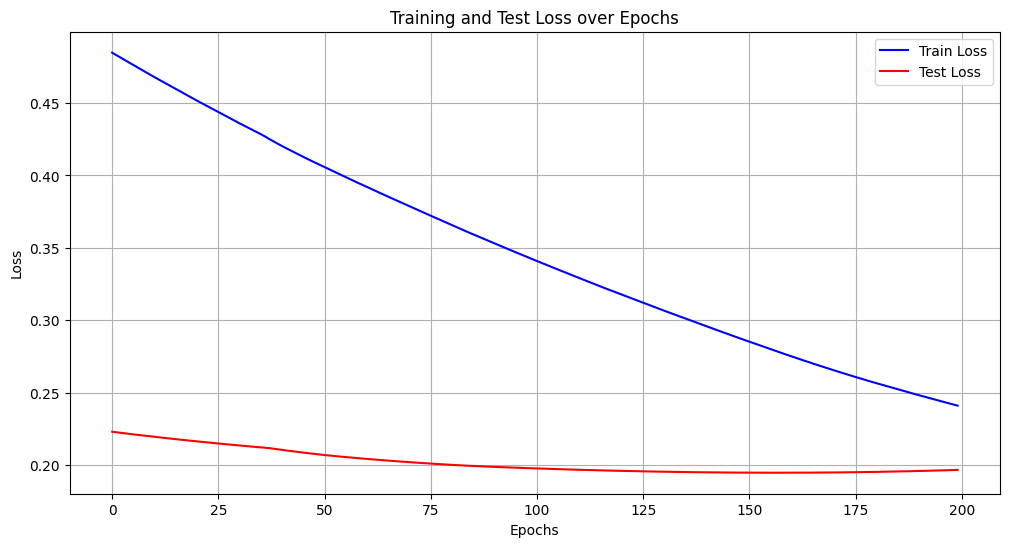

In [16]:
# Plotting the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label="Train Loss", color="blue")
plt.plot(test_loss_values, label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('../images/base_loss_plot.png')
plt.show()

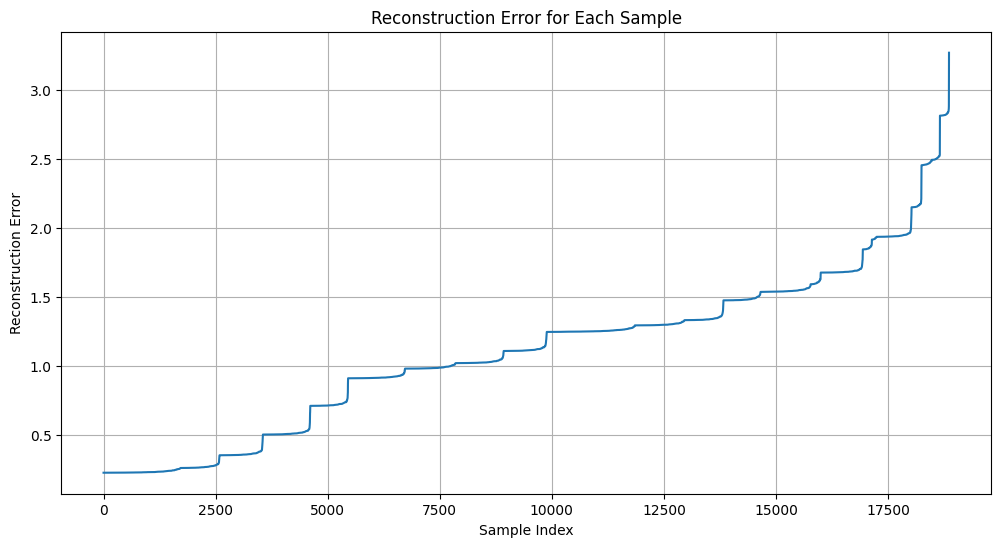

In [100]:
# sort and plot the reconstruction errors
reconstruction_errors.sort()
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors)
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Each Sample")
plt.grid(True)

In [52]:
pd.Series(reconstruction_errors).describe()

count   18861.000
mean        0.567
std         0.333
min         0.157
25%         0.295
50%         0.520
75%         0.692
max         1.952
dtype: float64

In [158]:
pd.Series(reconstruction_errors).describe()

count   18861.000
mean       95.171
std        64.560
min         5.785
25%        30.547
50%        99.802
75%       150.832
max       280.447
dtype: float64

In [43]:
# show trainsactions where reconstruction error is greater is in top 1%
threshold = np.percentile(reconstruction_errors, 99)
print(f"Threshold: {threshold:.4f}")

Threshold: 2.2204


# Evaluations
F1, Precision, Recall, Accuracy, ROC_AUC

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Reconstruct the test data
with torch.no_grad():
    reconstructed_test = model(test_tensor).numpy()

In [21]:
# Calculate reconstruction error
reconstruction_errors = np.mean(np.power(test_data - reconstructed_test, 2), axis=1)

# Choose a threshold based on domain knowledge, the distribution of reconstruction errors, or via a validation set.
threshold = np.percentile(reconstruction_errors, 98)  # e.g., 99th percentile as threshold. This is a naive approach; refine based on your needs.

# Convert reconstruction errors into binary labels (0 or 1)
predicted_labels = [1 if error > threshold else 0 for error in reconstruction_errors]

# Convert reconstruction errors into probabilities between 0 and 1
predicted_probabilities = (reconstruction_errors - min(reconstruction_errors)) / (max(reconstruction_errors) - min(reconstruction_errors))

# Assuming df has a 'reported' column with true labels
true_labels = df['reported'].loc[test_data.index].values

In [22]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.0170
Precision: 0.0132
Recall: 0.0238
Accuracy: 0.9694
ROC AUC: 0.6797
False Positive Rate (FPR): 0.0200


In [23]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.0170
Precision: 0.0132
Recall: 0.0238
Accuracy: 0.9694
ROC AUC: 0.6797
False Positive Rate (FPR): 0.0200


In [169]:
# Calculate metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
fpr = fp / (fp + tn)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.1016
Precision: 0.0847
Recall: 0.1270
Accuracy: 0.9700
ROC AUC: 0.6900
False Positive Rate (FPR): 0.0186


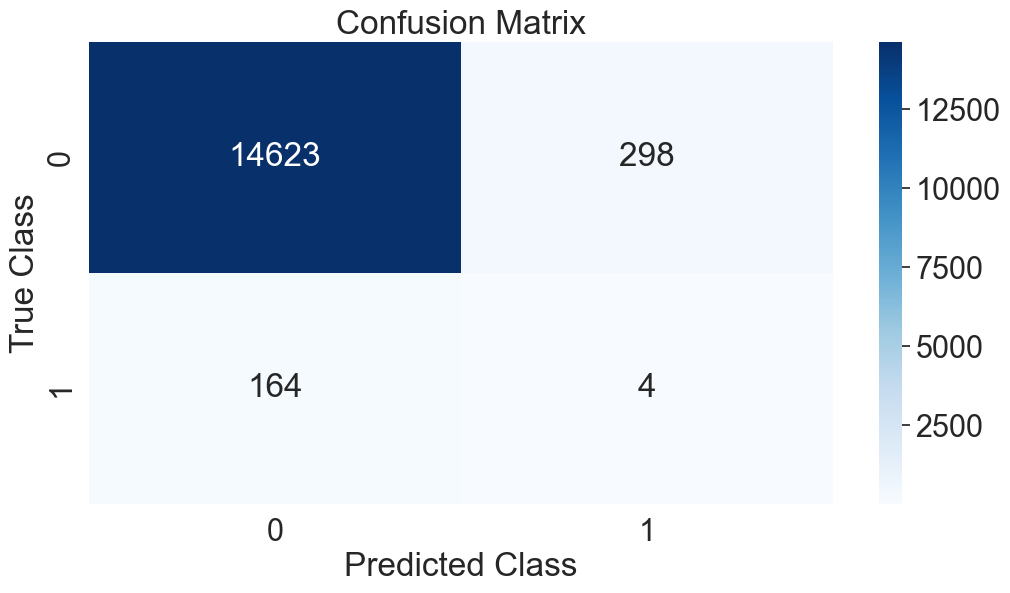

In [31]:
# heatmap of confusion matrix
import seaborn as sns

sns.set(font_scale=2)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('../images/base_confusion_matrix.png')
plt.show()

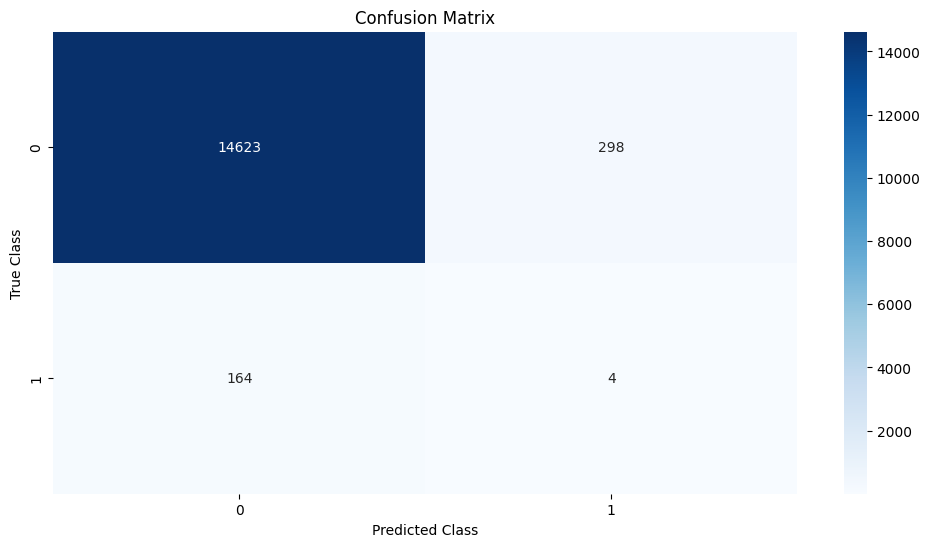

In [24]:
# heatmap of confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('../images/base_confusion_matrix.png')
plt.show()

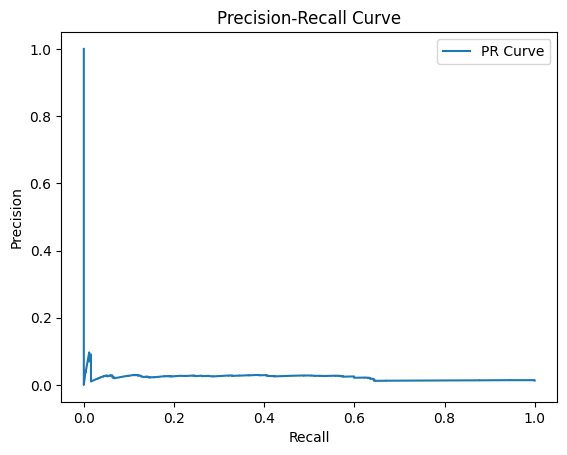

In [105]:
# 1. PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(recall_vals, precision_vals, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

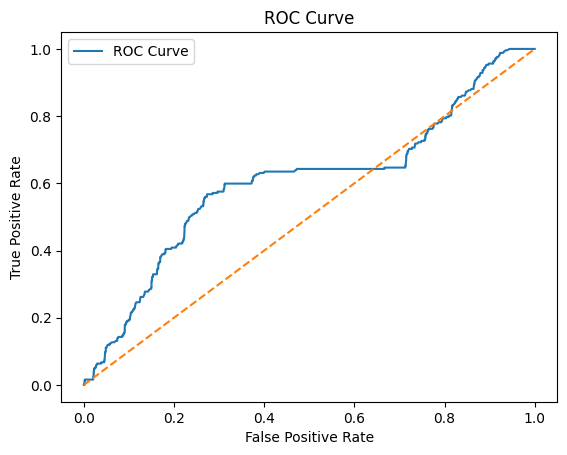

In [106]:
# 2. ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(true_labels, predicted_probabilities)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

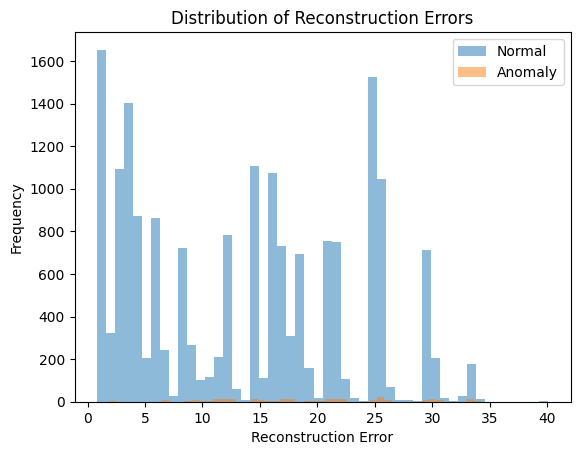

In [176]:
# 3. Distribution of Reconstruction Errors
plt.figure()
plt.hist(reconstruction_errors[true_labels == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(reconstruction_errors[true_labels == 1], bins=50, alpha=0.5, label='Anomaly')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

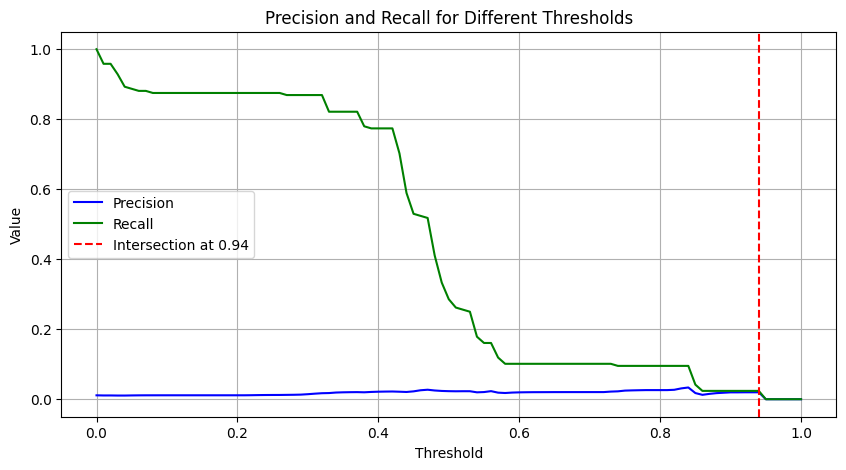

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming the other parts of your code, where you compute `predicted_probabilities` and `true_labels`, are above this

# List to store precision and recall values for each threshold
precisions = []
recalls = []

# Iterate over a range of thresholds (e.g., from 0 to 1 with a step of 0.01)
thresholds = np.arange(0, 1.01, 0.01)  # Adjust the range and step as needed

for threshold in thresholds:
    # Calculate predicted labels for this threshold
    predicted_labels_threshold = [1 if error > threshold else 0 for error in predicted_probabilities]
    
    # Avoiding a scenario where there's a perfect precision or recall which can cause "UndefinedMetricWarning"
    if len(np.unique(predicted_labels_threshold)) > 1:
        # Compute precision and recall
        precision = precision_score(true_labels, predicted_labels_threshold)
        recall = recall_score(true_labels, predicted_labels_threshold)
    else:
        precision, recall = 0, 0

    precisions.append(precision)
    recalls.append(recall)

# Find the threshold where precision and recall cross
diffs = np.array(precisions) - np.array(recalls)
cross_points = np.where(np.diff(np.sign(diffs)))[0]  # Where the difference changes sign

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')

# If there's an intersection point, plot it
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]
    plt.axvline(x=cross_threshold, color='red', linestyle='--', label=f'Intersection at {cross_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall for Different Thresholds')
plt.legend()
plt.grid(True)
plt.savefig('../images/base_precision_recall_threshold.png')
plt.show()


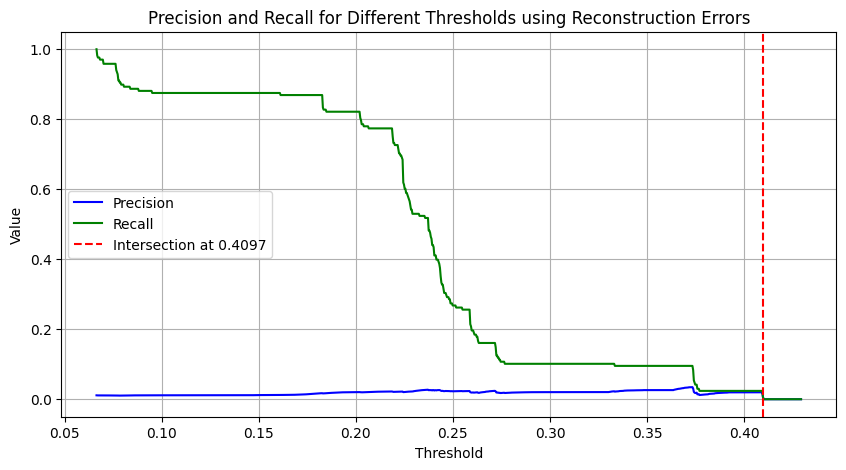

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# List to store precision and recall values for each threshold
precisions = []
recalls = []

# Iterate over a range of thresholds, dynamically determined from the range of your reconstruction_errors
thresholds = np.linspace(min(reconstruction_errors), max(reconstruction_errors), 1000)

for threshold in thresholds:
    # Convert reconstruction errors to binary labels based on the current threshold
    predicted_labels_threshold = [1 if error > threshold else 0 for error in reconstruction_errors]
    
    # Avoiding a scenario where there's a perfect precision or recall which can cause "UndefinedMetricWarning"
    if len(np.unique(predicted_labels_threshold)) > 1:
        # Compute precision and recall
        precision = precision_score(true_labels, predicted_labels_threshold)
        recall = recall_score(true_labels, predicted_labels_threshold)
    else:
        precision, recall = 0, 0

    precisions.append(precision)
    recalls.append(recall)

# Find the threshold where precision and recall cross
diffs = np.array(precisions) - np.array(recalls)
cross_points = np.where(np.diff(np.sign(diffs)))[0]  # Where the difference changes sign

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')

# If there's an intersection point, plot it
if len(cross_points) > 0:
    cross_threshold = thresholds[cross_points[0]]
    plt.axvline(x=cross_threshold, color='red', linestyle='--', label=f'Intersection at {cross_threshold:.4f}')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall for Different Thresholds using Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()


## Based on reconstruction error threshold

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix


# Using the cross_threshold from previous code
predicted_labels_cross_threshold = [1 if error > cross_threshold else 0 for error in reconstruction_errors]

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels_cross_threshold)
precision = precision_score(true_labels, predicted_labels_cross_threshold)
recall = recall_score(true_labels, predicted_labels_cross_threshold)
accuracy = accuracy_score(true_labels, predicted_labels_cross_threshold)

# Convert reconstruction errors into probabilities between 0 and 1 for ROC AUC calculation
predicted_probabilities = (reconstruction_errors - min(reconstruction_errors)) / (max(reconstruction_errors) - min(reconstruction_errors))
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Calculate FPR
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_cross_threshold).ravel()
fpr = fp / (fp + tn)

# Print out the metrics
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'False Positive Rate (FPR): {fpr:.4f}')

F1 Score: 0.0057
Precision: 0.0055
Recall: 0.0060
Accuracy: 0.9770
ROC AUC: 0.6797
False Positive Rate (FPR): 0.0121


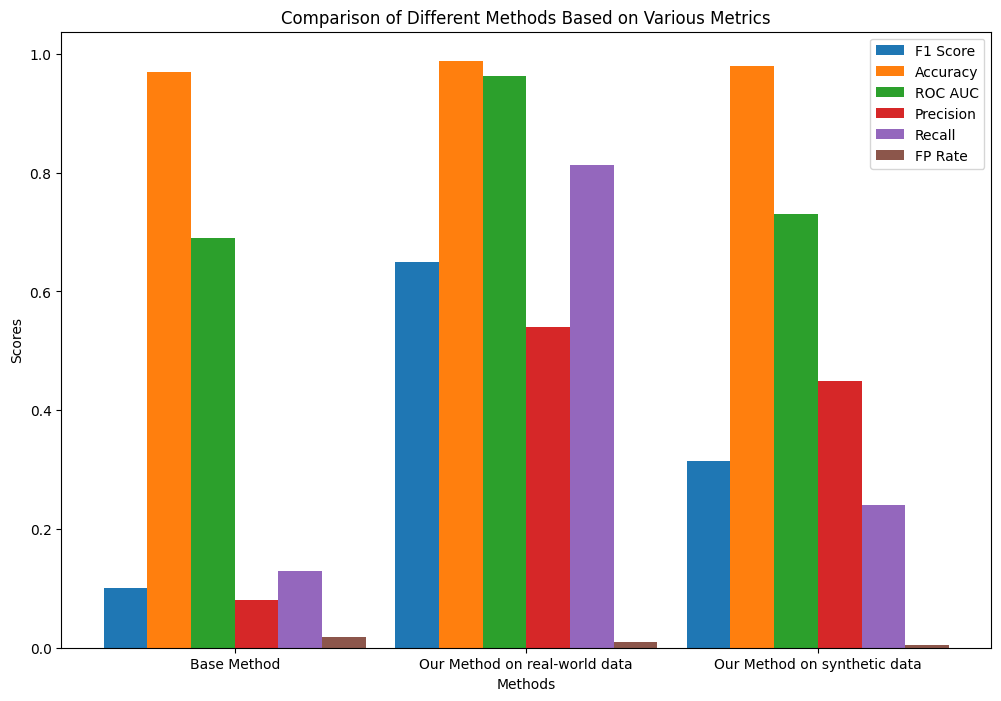

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
methods = ['Base Method', 'Our Method on real-world data', 'Our Method on synthetic data']
f1_scores = [0.10, 0.65, 0.315]
accuracies = [0.97, 0.988, 0.98]
roc_aucs = [0.69, 0.963, 0.73]
precisions = [0.08, 0.54, 0.45]
recalls = [0.13, 0.813, 0.24]
fp_rates = [0.018, 0.009, 0.005]

# Number of groups
num_groups = len(methods)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the bar width and positions
bar_width = 0.15
index = np.arange(num_groups)

# Create bars for each metric
ax.bar(index, f1_scores, bar_width, label='F1 Score')
ax.bar(index + bar_width, accuracies, bar_width, label='Accuracy')
ax.bar(index + 2*bar_width, roc_aucs, bar_width, label='ROC AUC')
ax.bar(index + 3*bar_width, precisions, bar_width, label='Precision')
ax.bar(index + 4*bar_width, recalls, bar_width, label='Recall')
ax.bar(index + 5*bar_width, fp_rates, bar_width, label='FP Rate')

# Add labels, title, and legend
ax.set_xlabel('Methods')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Methods Based on Various Metrics')
ax.set_xticks(index + 2.5*bar_width)
ax.set_xticklabels(methods)
ax.legend()
plt.savefig('../images/base_comparison.png')
# Show the plot
plt.show()


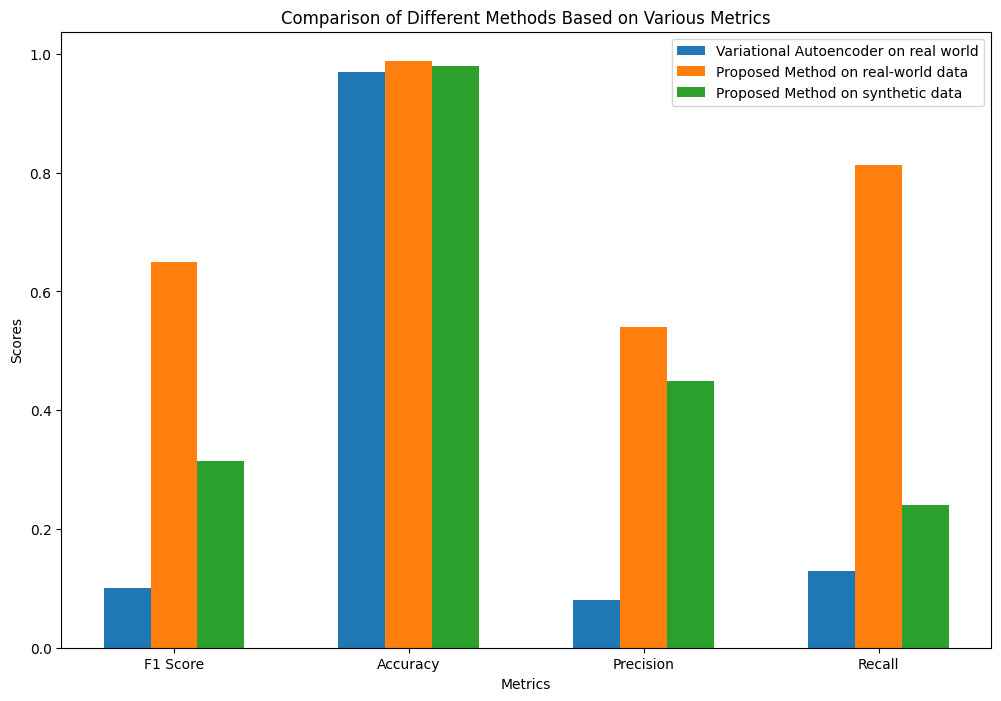

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
base_method = [0.10, 0.97, 0.08, 0.13]
our_method_real = [0.65, 0.988, 0.54, 0.813, ]
our_method_synthetic = [0.315, 0.98, 0.45, 0.24]

# Number of metrics
num_metrics = len(metrics)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the bar width and positions
bar_width = 0.2
index = np.arange(num_metrics)

# Create bars for each method
ax.bar(index - bar_width, base_method, bar_width, label='Variational Autoencoder on real world')
ax.bar(index, our_method_real, bar_width, label='Proposed Method on real-world data')
ax.bar(index + bar_width, our_method_synthetic, bar_width, label='Proposed Method on synthetic data')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Methods Based on Various Metrics')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()
plt.savefig('../images/base_comparison.png')
# Show the plot
plt.show()

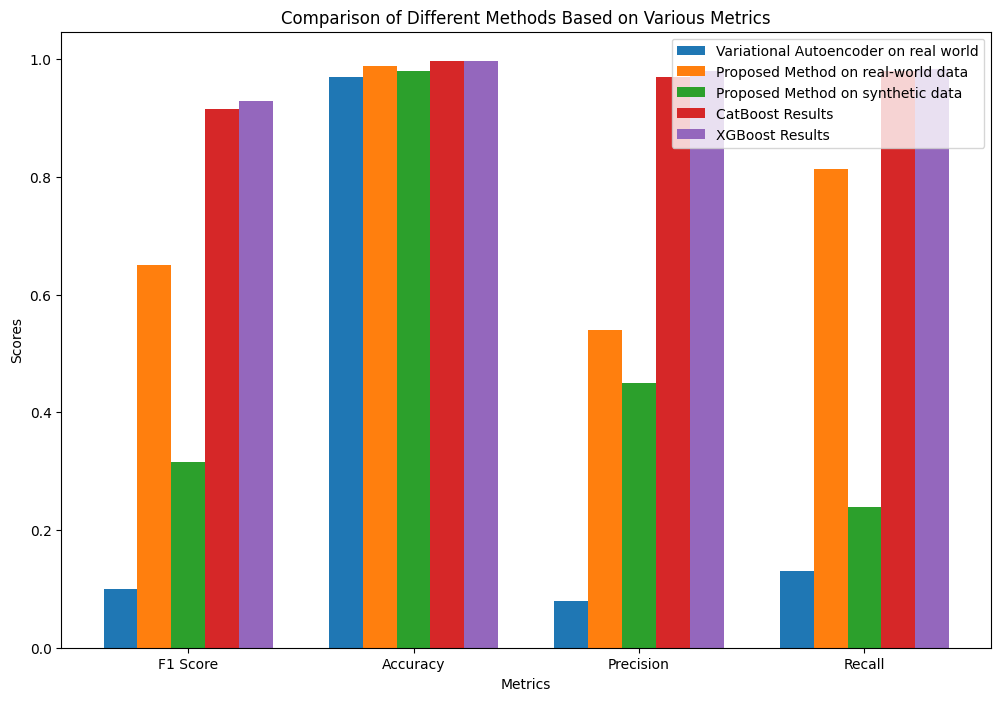

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
base_method = [0.10, 0.97, 0.08, 0.13]
our_method_real = [0.65, 0.988, 0.54, 0.813]
our_method_synthetic = [0.315, 0.98, 0.45, 0.24]
catboost = [0.916, 0.9971, 0.97, 0.98]  # Adjusted to match the number of metrics
xgboost = [0.93, 0.997, 0.98, 0.984]    # Adjusted to match the number of metrics

# Number of metrics
num_metrics = len(metrics)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the bar width and positions
bar_width = 0.15
index = np.arange(num_metrics)

# Create bars for each method
ax.bar(index - 2*bar_width, base_method, bar_width, label='Variational Autoencoder on real world')
ax.bar(index - bar_width, our_method_real, bar_width, label='Proposed Method on real-world data')
ax.bar(index, our_method_synthetic, bar_width, label='Proposed Method on synthetic data')
ax.bar(index + bar_width, catboost, bar_width, label='CatBoost Results')
ax.bar(index + 2*bar_width, xgboost, bar_width, label='XGBoost Results')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Methods Based on Various Metrics')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()
plt.savefig('../images/base_comparison_full.png')

# Show the plot
plt.show()
